This notebook has been completed using the following source:
    https://machinelearningmastery.com/?s=Household+Electricity&post_type=post&submit=Search

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [3]:
dataset = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [4]:
dataset.replace('?', np.nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

In [5]:
# filling in missing values with the same time but previous days
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

fill_missing(dataset.values)

In [6]:
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

dataset['sub_metering_4'] = dataset['sub_metering_4'].astype('float64').round(3)

In [7]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.267
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,70.567
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,71.800
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,43.100


In [8]:
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum().astype('float64')
# summarize
print(daily_data.shape)
display(daily_data.head().round(2))

(1442, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.18,34.92,93552.53,5180.8,0.0,546.0,4926.0,14680.93
2006-12-17,3390.46,226.01,345725.31,14398.6,2033.0,4187.0,13341.0,36946.67
2006-12-18,2203.83,161.79,347373.62,9247.2,1063.0,2621.0,14018.0,19028.44
2006-12-19,1666.19,150.94,348479.00,7094.0,839.0,7602.0,6197.0,13131.89
2006-12-20,2225.75,161.00,348923.62,9313.0,0.0,2648.0,14063.0,20384.80


In [9]:
daily_data.to_csv('household_power_consumption_days.csv')

In [10]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = np.array(np.split(train, len(train)/7))
	test = np.array(np.split(test, len(test)/7))
	return train, test

In [11]:
train, test = split_dataset(daily_data.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.4599609375 1309.2679443359375
(46, 7, 8)
2083.4541015625 2197.006103515625


In [12]:
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = np.array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [13]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# Persistence Forecast

In [14]:
# daily persistence model
def daily_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	# get the total active power for the last day
	value = last_week[-1, 0]
	# prepare 7 day forecast
	forecast = [value for _ in range(7)]
	return forecast

In [15]:
# weekly persistence model
def weekly_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	return last_week[:, 0]

In [16]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
	# get the data for the prior week
	last_week = history[-52]
	return last_week[:, 0]

In [17]:
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# split into train and test
train, test = split_dataset(dataset.values)

In [18]:
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


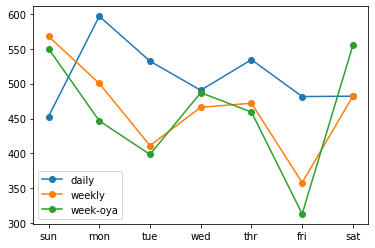

In [19]:
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# Autocorrelation Analysis

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [21]:
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = np.array(series).flatten()
	return series

In [22]:
series = to_series(train)

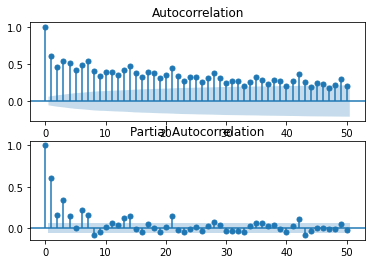

In [23]:
# plots
pyplot.figure()
lags = 50
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

## ARIMA Model

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
# arima forecast
def arima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = ARIMA(series, order=(7,0,0))
	# fit the model
	model_fit = model.fit()
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat

In [26]:
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
models['arima'] = arima_forecast

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1
arima: [381.301] 393.6, 398.3, 356.2, 377.0, 392.9, 304.8, 433.4


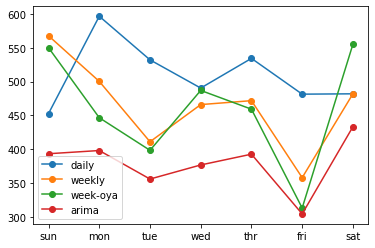

In [27]:
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

## SARIMA Model

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
# arima forecast
def sarima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = SARIMAX(series, order=(7,0,0), seasonal_order=(0, 0, 0, 365))
	# fit the model
	model_fit = model.fit()
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat

In [30]:
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
models['arima'] = arima_forecast
models['sarima'] = sarima_forecast

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1
arima: [381.301] 393.6, 398.3, 356.2, 377.0, 392.9, 304.8, 433.4
sarima: [393.614] 406.6, 411.6, 366.9, 387.5, 408.9, 321.6, 441.0


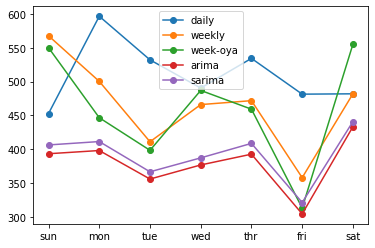

In [31]:
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# Recursive Multi-Step Forecasting


In [32]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression

In [33]:
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	models['bayesianridge'] = BayesianRidge()
	models['ard'] = ARDRegression()
	print('Defined %d models' % len(models))
	return models

In [34]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

In [35]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
	yhat_sequence = list()
	input_data = [x for x in input_x]
	for j in range(7):
		# prepare the input data
		X = array(input_data[-n_input:]).reshape(1, n_input)
		# make a one-step forecast
		yhat = model.predict(X)[0]
		# add to the result
		yhat_sequence.append(yhat)
		# add the prediction to the input
		input_data.append(yhat)
	return yhat_sequence

In [36]:
# convert history into inputs and outputs
def to_supervised(history, n_input):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		# ensure we have enough data for this instance
		if ix_end < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_end])
		# move along one time step
		ix_start += 1
	return array(X), array(y)

In [37]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	# prepare data
	train_x, train_y = to_supervised(history, n_input)
	# make pipeline
	pipeline = make_pipeline(model)
	# fit the model
	pipeline.fit(train_x, train_y)
	# predict the week, recursively
	yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
	return yhat_sequence

In [38]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

Defined 12 models
lr: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
lasso: [386.838] 403.6, 388.9, 337.3, 371.1, 406.1, 307.6, 471.6
ridge: [387.659] 407.9, 388.6, 337.5, 371.2, 407.0, 307.7, 471.7
en: [469.337] 452.2, 451.9, 435.8, 485.7, 460.4, 405.8, 575.1
huber: [392.465] 412.1, 388.0, 337.9, 377.3, 405.6, 306.9, 492.5
lars: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
llars: [388.406] 396.1, 387.8, 339.3, 377.8, 402.9, 310.3, 481.9
pa: [398.289] 412.9, 390.1, 341.8, 385.9, 409.8, 312.3, 506.5
ranscac: [457.489] 461.2, 438.5, 378.5, 429.8, 501.0, 379.8, 580.3
sgd: [387.685] 406.6, 389.8, 337.5, 371.1, 408.0, 307.9, 471.1
bayesianridge: [388.155] 410.0, 388.9, 337.9, 370.9, 408.1, 308.1, 471.2
ard: [387.690] 408.7, 388.7, 337.6, 370.7, 407.7, 308.0, 470.7


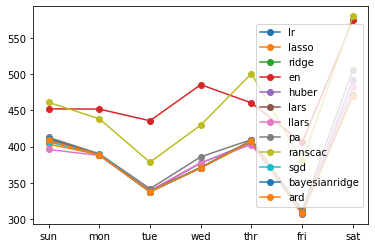

In [39]:
models = get_models()
n_input = 7
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, model in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(model, train, test, n_input)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# Direct Multi-Step Forecasting

In [40]:
# evaluate a single model
def evaluate_model(model, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [41]:
# convert history into inputs and outputs
def to_supervised(history, output_ix):
	X, y = list(), list()
	# step over the entire history one time step at a time
	for i in range(len(history)-1):
		X.append(history[i][:,0])
		y.append(history[i + 1][output_ix,0])
	return array(X), array(y)

In [42]:

# fit a model and make a forecast
def sklearn_predict(model, history):
	yhat_sequence = list()
	# fit a model for each forecast day
	for i in range(7):
		# prepare data
		train_x, train_y = to_supervised(history, i)
		# make pipeline
		pipeline = make_pipeline(model)
		# fit the model
		pipeline.fit(train_x, train_y)
		# forecast
		x_input = array(train_x[-1, :]).reshape(1,7)
		yhat = pipeline.predict(x_input)[0]
		# store
		yhat_sequence.append(yhat)
	return yhat_sequence

Defined 12 models
lr: [410.927] 463.8, 381.4, 351.9, 430.7, 387.8, 350.4, 488.8
lasso: [408.440] 458.4, 378.5, 352.9, 429.5, 388.0, 348.0, 483.5
ridge: [403.875] 447.1, 377.9, 347.5, 427.4, 384.1, 343.4, 479.7
en: [454.263] 471.8, 433.8, 415.8, 477.4, 434.4, 373.8, 551.8
huber: [409.500] 466.8, 380.2, 359.8, 432.4, 387.0, 351.3, 470.9
lars: [410.927] 463.8, 381.4, 351.9, 430.7, 387.8, 350.4, 488.8
llars: [406.490] 453.0, 378.8, 357.3, 428.1, 388.0, 345.0, 476.9
pa: [402.668] 434.5, 379.2, 361.0, 427.9, 390.4, 349.3, 463.2
ranscac: [460.685] 475.9, 388.8, 410.1, 516.4, 481.1, 438.4, 499.4
sgd: [403.476] 452.0, 378.6, 347.5, 427.6, 381.2, 344.5, 473.6
bayesianridge: [406.280] 456.4, 378.3, 348.3, 428.1, 384.5, 346.6, 481.1
ard: [407.322] 453.7, 380.1, 362.0, 427.7, 390.3, 346.0, 474.4


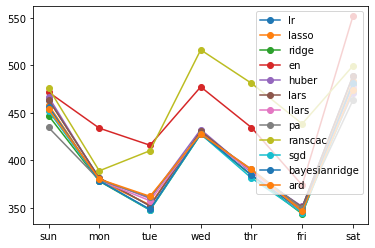

In [43]:
models = get_models()
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, model in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(model, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# Direct Lead Time Approach

In [44]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	yhat_sequence = list()
	# fit a model for each forecast day
	for i in range(7):
		# prepare data
		train_x, train_y = to_supervised(history, n_input, i)
		# make pipeline
		pipeline = make_pipeline(model)
		# fit the model
		pipeline.fit(train_x, train_y)
		# forecast
		x_input = array(train_x[-1, :]).reshape(1,n_input)
		yhat = pipeline.predict(x_input)[0]
		# store
		yhat_sequence.append(yhat)
	return yhat_sequence

In [45]:
# convert history into inputs and outputs
def to_supervised(history, n_input, output_ix):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix
		# ensure we have enough data for this instance
		if ix_output < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_output])
		# move along one time step
		ix_start += 1
	return array(X), array(y)

In [46]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

lr: [394.983] 411.0, 400.7, 340.2, 382.9, 385.1, 362.8, 469.4
lasso: [391.767] 403.6, 394.4, 336.1, 382.7, 384.2, 360.4, 468.1
ridge: [393.444] 407.9, 397.8, 338.9, 383.2, 383.2, 360.4, 469.6
en: [461.986] 452.2, 448.3, 430.3, 480.4, 448.9, 396.0, 560.6
huber: [394.287] 412.1, 394.0, 333.4, 384.1, 383.1, 364.3, 474.4
lars: [394.983] 411.0, 400.7, 340.2, 382.9, 385.1, 362.8, 469.4
llars: [390.075] 396.1, 390.1, 334.3, 384.4, 385.2, 355.6, 470.9
pa: [394.172] 416.3, 390.5, 331.9, 387.4, 378.3, 357.4, 480.3
ranscac: [454.168] 486.3, 459.9, 375.3, 433.3, 418.8, 436.0, 549.4
sgd: [391.119] 405.1, 393.1, 336.2, 384.2, 379.6, 357.5, 468.7
bayesianridge: [394.283] 410.0, 399.3, 339.6, 383.0, 384.1, 361.5, 469.5
ard: [392.969] 408.7, 395.9, 337.2, 382.4, 384.7, 362.5, 466.8


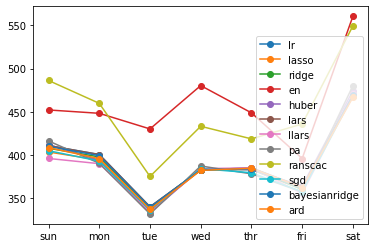

In [47]:
n_input = 7
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, model in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(model, train, test, n_input)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

# CNNs for Multi-Step Forecasting

For more information on CNN: https://machinelearningmastery.com/crash-course-convolutional-neural-networks/

## Multi-step Time Series Forecasting With a Univariate CNN

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [49]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [50]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [51]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 5
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.1))
	model.add(Dense(64, activation='relu'))
	model.add(Dropout(0.1))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [52]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [53]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

### Weekly

cnn: [406.561] 440.8, 405.1, 359.9, 412.4, 403.4, 315.7, 486.4


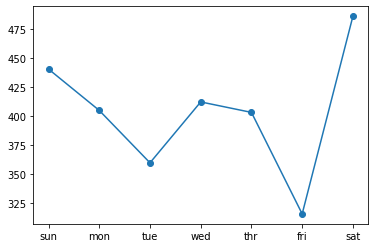

In [54]:
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

### 2 Weeks

cnn: [393.568] 397.5, 378.9, 406.6, 402.4, 398.5, 328.0, 434.7


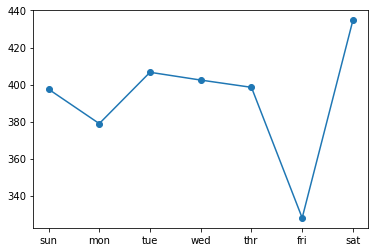

In [55]:
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

## Multi-step Time Series Forecasting With a Multichannel CNN


In [56]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [57]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [58]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [59]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [60]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

cnn: [399.965] 421.0, 377.2, 334.0, 464.4, 348.3, 313.7, 503.3


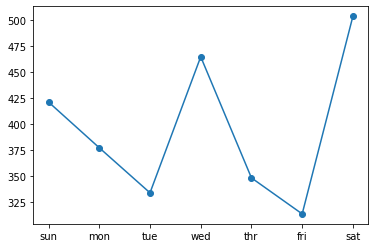

In [61]:
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

# Multi-step Time Series Forecasting With a Multihead CNN


In [62]:
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

In [63]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# plot the model
	plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [64]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [65]:
# plot training history
def plot_history(history):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='test')
	pyplot.title('loss', y=0, loc='center')
	pyplot.legend()
	# plot rmse
	pyplot.subplot(2, 1, 2)
	pyplot.plot(history.history['rmse'], label='train')
	pyplot.plot(history.history['val_rmse'], label='test')
	pyplot.title('rmse', y=0, loc='center')
	pyplot.legend()
	pyplot.show()

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

cnn: [428.345] 590.2, 424.6, 410.6, 408.5, 381.9, 315.7, 418.1


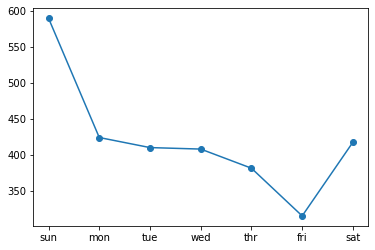

In [66]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()